In [1]:
%matplotlib inline
import data
import numpy as np
import matplotlib.pyplot as plt
from classifiers import GRL_classifier, build_sequential_model
import stats
from keras.utils import np_utils

Using Theano backend.


In [2]:
data_folder = "./"
X, y, _, _, _ = data.load(data_folder + "training.csv", shuffle=True)
Xa, ya, wa, _, _ = data.load(data_folder + "check_agreement.csv", shuffle=False, weight=True)
Xa_train, ya_train, _, _, _ = data.load(data_folder + "check_agreement.csv", shuffle=True)
Xc, _, _, mc, _ = data.load(data_folder + "check_correlation.csv", shuffle=False, mass=True, test=True)

X, scaler = data.preprocess_data(X)
Xa, _ = data.preprocess_data(Xa, scaler)
Xa_train, _ = data.preprocess_data(Xa_train, scaler)
Xc, _ = data.preprocess_data(Xc, scaler)

y_categorical = np_utils.to_categorical(y)
ya_categorical = np_utils.to_categorical(ya_train)

X_test, _, _, _, ids = data.load("test.csv", test=True, ids=True)
X_test, _ = data.preprocess_data(X_test, scaler)

In [3]:
from keras.layers import PReLU, Dropout, Dense

def feature_extractor(input_size, output_size):
    return build_sequential_model([Dense(150, input_dim=input_size),
                                   PReLU(), Dropout(0.5), Dense(140),
                                   PReLU(), Dropout(0.45), Dense(120),
                                   PReLU(), Dropout(0.42), Dense(110),
                                   PReLU(), Dropout(0.4), Dense(output_size), PReLU()],
                                  name="feature_extractor")

def label_classifier(input_size, name="label_classifier"):
    return build_sequential_model([Dense(90, input_dim=input_size),
                                  PReLU(), Dropout(0.4), Dense(80),
                                  PReLU(), Dropout(0.35), Dense(70),
                                  PReLU(), Dropout(0.3), Dense(2, activation='softmax')],
                                  name=name)

In [4]:
n_epochs = 400
np.random.seed(42)
n_extracted_features = 100
transfering_ratio = 0
# steps = 10
# lambda_step = 0.1

ks_plot, cvm_plot, auc_plot = [], [], []
plots = [ks_plot, cvm_plot, auc_plot]

In [5]:
# Learning on train
f = feature_extractor(X.shape[1], n_extracted_features)
l = label_classifier(n_extracted_features)
d = label_classifier(n_extracted_features, name="domain_classifier")
model = GRL_classifier(f, l, d, 2)

metrics_callback = stats.ShowMetrics(model, Xa, ya, wa, Xc, mc, X, y_categorical, verbose=True)

In [7]:
# Transfering to check_agreement
lam = 2
while True:
    print('lambda = ', lam)
    model.fit(X, y_categorical, y_categorical,
              epoch_count=50,
              batch_size=64, validation_split=0.02, verbose=2,
              callbacks=[metrics_callback])
    if metrics_callback.get_history()[0][-1] < 0.09 and metrics_callback.get_history()[1][-1] < 0.02:
        probs = model.predict_probs(np.array(X_test))
        data.save_submission(ids, probs, "grl_prediction_{}_{}.csv"
                             .format(lam, metrics_callback.get_history()[0][-1]))

lambda =  2
Train on 66201 samples, validate on 1352 samples
Epoch 1/50
KS: 0.06735249984919606 : 0.09 / CvM: 0.0009981238904955636 : 0.002 / AUC: 0.9465870048913201
30s - loss: 1.3604 - label_classifier_acc: 0.6131 - domain_classifier_acc: 0.5976 - val_loss: 1.2889 - val_label_classifier_acc: 0.6339 - val_domain_classifier_acc: 0.6331
Epoch 2/50
KS: 0.08550599943110576 : 0.09 / CvM: 0.0009208000808317271 : 0.002 / AUC: 0.9559951205224535
29s - loss: 1.2918 - label_classifier_acc: 0.6554 - domain_classifier_acc: 0.6126 - val_loss: 1.1263 - val_label_classifier_acc: 0.7419 - val_domain_classifier_acc: 0.6331
Epoch 3/50
KS: 0.08531171984514835 : 0.09 / CvM: 0.0009293411945119744 : 0.002 / AUC: 0.9685314383702435
29s - loss: 1.2040 - label_classifier_acc: 0.7272 - domain_classifier_acc: 0.6246 - val_loss: 1.0468 - val_label_classifier_acc: 0.8047 - val_domain_classifier_acc: 0.6383
Epoch 4/50
KS: 0.07776693543825758 : 0.09 / CvM: 0.0009700797828403443 : 0.002 / AUC: 0.9778088709464919
29s

KeyboardInterrupt: 

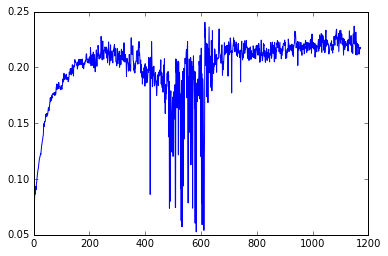

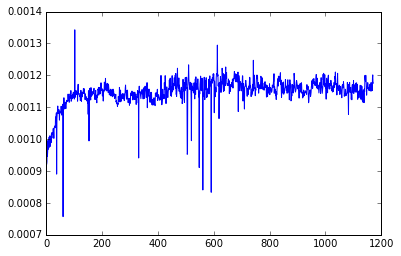

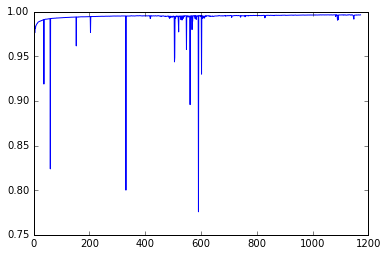

In [8]:
plt.plot(metrics_callback.get_history()[0], label='KS')
plt.show()
plt.plot(metrics_callback.get_history()[1], label='CVM')
plt.show()
plt.plot(metrics_callback.get_history()[2], label='AUC')
plt.show()

In [ ]:
probs = model.predict_probs(np.array(X_test))
data.save_submission(ids, probs, "grl_prediction.csv")
!zip -9 -r grl_prediciton.csv.zip grl_prediction.csv